# Python and the data


- [Text and binary](#Text-and-binary): streaming, serialization, regular expression
- [The Web](#The-Web): XML parsing, html scraping, web frameworks, API calls
- [Data Storage](#Data-storage): SQLite, SQL querrying, Chunking and HDF5, pytables
- [Python and other languages](#Python-and-other-languages): C, R, Julia

## Text and binary

Text manipulation is quite simplified in Python thanks to a wide variety of packages. It is generally advisable not to reinvent the wheels, so only perform quick and dirty regular expression based text parsing when it is really necessary. This is because complex RE parsing is hard to decode and test properly.

### File streaming

In the tutorial we exercised raw text file opening in Python. What if we want to read text from the standard input? (Useful for pipelining, and generally for saving space.)

In [5]:
#use like this: cat file.txt | python script.py
import sys
for line in sys.stdin:
    # do suff
    print(line)

Text streaming involves using only the communication layer and the RAM, and not storing the data on disk immediately. When is this useful:
- You want to use input from a dozen of super large archived FASTQ files.
- You want to asynchronuously write to a couple of output files, in cases when you are using multuthreading or multiprocessing.
- You want to pipe the result of a Python computation straight into some program running on another machine, another cluster node etc.

In [3]:
import io

# Writing to a buffer
output = io.StringIO()
output.write('FIrst stream into the buffer. ')
print('Second stream.', file=output)

# Retrieve the value written
print(output.getvalue())

output.close()  # discard buffer memory

# Initialize a read buffer
input = io.StringIO('Inital value for read buffer')

# Read from the buffer
print(input.read())

print("Second read output:",input.read())


FIrst stream into the buffer. Second stream.

Inital value for read buffer
Second read output: 


Task:
- create a text file and deposit random tab separated numbers in it, then archive it using the gzip module.
- Open the file as a byte stream input and decode it to ascii using the io.TextIOWrapper class.
- Make a second version where you open the stream outside python using the gzip program (or tar). Time the difference.

### Pickling

This in Python jargon means object serialization, a very important feature allowing you to save on disk the contents of a Python datastructure directly, in a specially compressed or sometimes binary format.

In [2]:
d = {'first': [1,"two"], 'second': set([3, 4, 'five'])}
import pickle
with open('dumpfile.pkl','wb') as fout:
    pickle.dump(d, fout)
with open('dumpfile.pkl','rb') as fin:
    d2 = pickle.load(fin)
print(d2)

{'first': [1, 'two'], 'second': {'five', 3, 4}}


### JSON

A short word for JavaScript Object Notation, .json became ubiquitous as a simple data interchange format mainly in remote Web API calls and microtransactions. Json is easily loaded into native Python datastructures. An example:

In [3]:
import json
#json_string = json.dumps([1, 2, 3, "a", "b", "c"])
d = {'first': [1,"two"], 'second': [3, 4, 'five']}
json_string = json.dumps(d)
print(json_string)


{"first": [1, "two"], "second": [3, 4, "five"]}


### Feather

When it comes to fast serialization between R and Python, the current champion is [Feather](https://github.com/wesm/feather). However, since any disk operation is limited by the mechanics of the disk, for extreme performance it is recommended to keep the serialized objects in memory or use SSDs.

In [ ]:
%%R
library(feather)
path <- "my_data.feather"
write_feather(df, path)
df <- read_feather(path)

In [ ]:
import feather
path = 'my_data.feather'
feather.write_dataframe(df, path)
df = feather.read_dataframe(path)

# Parsing and regular expressions

Used for any raw text format in biology, such as (FASTA, FASTAQ, PDB, VCF, GFF, SAM).


Example: FASTA parsing

Open the file containing all peptide sequences in the human body.
How many unknown peptides does it contain?
How many unique genes and transcripts are in there for the unknown peptides?
Output a tab separated file containing the gene id and transcript id for each unknown peptide.

Observation:
Usage of Biopython and pandas modules.

Task:
Order the chromosomes by the number of unknown peptides versus the total number of peptides they translate.

>ENSP00000388523 pep:known chromosome:GRCh38:7:142300924:142301432:1 gene:ENSG00000226660 transcript:ENST00000455382 gene_biotype:TR_V_gene transcript_biotype:TR_V_gene
MDTWLVCWAIFSLLKAGLTEPEVTQTPSHQVTQMGQEVILRCVPISNHLYFYWYRQILGQ
KVEFLVSFYNNEISEKSEIFDDQFSVERPDGSNFTLKIRSTKLEDSAMYFCASSE

Task:
- Run the code below and figure out what I did. Python scripting is very often all about inheriting someone elses bloaded abandonware and making it work for you!

In [19]:
import sys
f = open('data/Homo_sapiens.GRCh38.pep.all.fa','r')
peptides = {}
for l in f:
    if l[0]=='>':
        #print l.strip().split()
        record = {}
        r = l.strip('\n').split()
        pepid = r[0][1:]
        record['pep'] = 1 if r[1].split(':')[1]=='known' else 0
        record['gene'] = r[3].split(':')[1]
        record['transcript'] = r[4].split(':')[1]
        peptides[pepid] = record
f.close()

##using regular expressions to match all known peptides
nupep2 = 0
import re
#pattern = re.compile('^>.*(known).*')
pattern = re.compile('^>((?!known).)*$')
with open('data/Homo_sapiens.GRCh38.pep.all.fa','rt') as f:
    for l in f:
        if pattern.search(l) is not None: nupep2 += 1 

npep = len(peptides)
upep = set([pepid for pepid in peptides if peptides[pepid]['pep']==0]) #unknown peptides
nunknown = len(upep)
genes = set([peptides[pepid]['gene'] for pepid in upep])
trans = set([peptides[pepid]['transcript'] for pepid in upep])
print(npep, nupep2, nunknown, len(genes), len(trans))


with open('unknown_peptides.txt','w') as f:
    for pepid in upep:
        f.write('\t'.join([pepid, peptides[pepid]['gene'], peptides[pepid]['transcript']])+'\n')


99436 28828 28828 11116 70608


You have seen an example of how text processing is done in Python using the standard libraries. However, you should only do this when your task is extremely unusual. For most other cases it is preferable to use a dedicated library. Most biological formats have dedicated libraries in Python, and when only available in another tool or language it is always preferable to glue a call.

Example: the "@" character in FASTQ is also a valid confidence score. If you make a hasted script matching for "@" as the deliniation of a new record, you might also end up with a corrupted result.

Task:

Here is an example of how you should do the task above. Run this via Jupyter as well.

In [ ]:
f = open('data/Homo_sapiens.GRCh38.pep.all.fa','r')
from Bio import SeqIO
fasta = SeqIO.parse(f,'fasta')

i = 0
name, sequence = fasta.id, fasta.seq.tostring()
if len(sequence)<100 and len(sequence)>20:
    i += 1
    print i
    print "Name",name
    print "Sequence",sequence
    if i > 5: break
f.close()

## The Web

A lot of the information today is web based, so Python has tools to help parsing the most popular web formats, web frameworks for client and server side processing, but also more mundane tasks such as web site scraping or making API calls.

### XML parsing

XML is a general file format used for data interchange, especially among different applications. One of the most popular use in Biology is the SBML format, that aims to store a biological model specification, no matter how specific that model may be.

Task:
- Download a curated SBML file from the BioModels database:
http://www.ebi.ac.uk/biomodels-main/
- Find out how many reactions the file contains.

Extra task:
- Make a simplified XML file of the reactants and their k-values for each reaction.

In [ ]:
import sys

import xml.etree.ElementTree as ET
tree = ET.ElementTree(file='data/curated_sbml.xml')
#tree = ET.parse(open('data/curated_sbml.xml'))
root = tree.getroot()
print root.tag, root.attrib
for child in root:
    print child.tag, child.attrib
    for child2 in child:
        print child2.tag, child2.attrib

#print tree.write(sys.stdout)
for elem in root.iter('reaction'):
    print elem.tag, elem.attrib

for elem in root.iter('species'):
    print elem.tag, elem.attrib
    print elem.get('id')

print tree.findall('.//reaction')

### xmltodict

The standard library option is recommended when making a program, but it will be an overkill when having to parse a file with a quick script. 

Task:
- download and install xmltodict, then list the reactions using this library.

In [ ]:
import xmltodict
with open('data/curated_sbml.xml','r') as fd:
    doc = xmltodict.parse(fd.read())
    

### Web scraping

This is concerned with automatic information processing from the Internet.

Task:
- Mine an online KEGG pathway for its reaction elements. 

[BeautifulSoup](http://www.pythonforbeginners.com/python-on-the-web/beautifulsoup-4-python/) is loved by hackers. Aside from html it can also parse xml.

Here is a small script that will list all web anchors from Reddit main page (an anchod is a html tag normally used to provide hyperlinks and reference points inside a web page).

In [ ]:
from bs4 import BeautifulSoup
import urllib2

redditFile = urllib2.urlopen("http://www.reddit.com")
redditHtml = redditFile.read()
redditFile.close()

soup = BeautifulSoup(redditHtml)
redditAll = soup.find_all("a")
for links in soup.find_all('a'):
    print (links.get('href'))

### Web Frameworks 

As a general purpose language, Python is very popular for server side scripting. If Javascript rules as the scripting language of the web client, on the web server Python is ubiquitous due to it's fast prototyping. Only very recently Javascript started to also be popular, with frameworks like node.js.

Why would this matter for you?
- You can present your research interactively.
- Interactivity also helps you work with your own data.
- A web interface allows anyone to inspect your data or your findings.
- It allows you to link your data to public datasets and the opposite.


#### Flask

Flask is a very capable microframework widely used for web development.

[http://flask.pocoo.org/](http://flask.pocoo.org/)

Task:
- Run the data/flasktest.py file and open the browser at :http://0.0.0.0:5001/hello


In [ ]:
# Do not run this cell!
from flask import Flask
app = Flask("the_flask_module")

@app.route("/hello")
def hello_page():
    return "I'm a hello page"

@app.route("/hello/details")
def hello_deeper():
    return "I'm a details page"

app.run(host="0.0.0.0", port=5001)

#### Django

Worth just mentioning [Django](https://docs.djangoproject.com/en/1.7/) is a similarly popular yet more mature web framework that was amont the first to use a model-view-controller architecture wich simplifies reusability. One can write entire websites only from python code and html templates, although in general Javascript is also used for complex websites along with manual database configurations.

#### Using Jupyter for web interaction

While it is possible to turn Jupyter into an interactive web form with buttons and other standard widgets, we will not have time to do this, as it would suppose to learn a lot of web development concepts. 

However, we presented an interactive example in the Jupyter section and we will also learn how to use Python to create interactive web plots inside the plotting chapter.

### Remote web API calls example

Getting information as fast as possible into our Python data structures is vital. Only as a last resource should one program his own downloaders and parsers. When this is not found in Python, it can be possible to call libraries from Perl or Python or access web records with specified API calls. BioPython wraps a few API calls such as Entrez resources. Entrez is a federated search engine over various NCBI and NIH resource databases. 

In [3]:
from Bio import Entrez
Entrez.email = "your@mail.here"     # Always tell NCBI who you are
handle = Entrez.einfo()
#result = handle.read()
record = Entrez.read(handle)
print(record.keys())
print(record["DbList"])

dict_keys(['DbList'])
['pubmed', 'protein', 'nuccore', 'nucleotide', 'nucgss', 'nucest', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'clone', 'gap', 'gapplus', 'grasp', 'dbvar', 'epigenomics', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'ncbisearch', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'probe', 'proteinclusters', 'pcassay', 'biosystems', 'pccompound', 'pcsubstance', 'pubmedhealth', 'seqannot', 'snp', 'sra', 'taxonomy', 'unigene', 'gencoll', 'gtr']


**[BioPython](http://biopython.org/wiki/Main_Page)**

So let us for example find the exact lineage for this amazing breed of bacteria that changed both plants and atmosphere in the earlier days of our planet... As biologists that try to learn Python, I hope you will love BioPython at least as much as I do. A number of programmers created Bio::Perl which is to date containing a few more modules than BioPython, however I got the feeling the Python version is more updated. It is unfortunate that we don't have time to explore it in a great detail. 
We will use it again over the course. 

Aside from BioPython, web API can be ofered by virtually any website and with a little effort one can either download an Python access package or program his own. Functional annotation for example, is weakly covered in Python, but [DAVID](http://david.abcc.ncifcrf.gov/content.jsp?file=WS.html) is another API independent from BioPython.

First, install with:

```
conda install -c https://conda.anaconda.org/anaconda biopython
```

In [9]:
from Bio import Entrez
Entrez.email = "your@mail.here"     # Always tell NCBI who you are
handle = Entrez.esearch(db="Taxonomy", term="Synechocystis")
record = Entrez.read(handle)
print(record["IdList"])
#assuming only one record is returned
handle = Entrez.efetch(db="Taxonomy", id=record["IdList"][0], retmode="xml")
records = Entrez.read(handle)
print(records[0].keys())
print(records[0]["Lineage"])

['1142']
dict_keys(['UpdateDate', 'ParentTaxId', 'GeneticCode', 'TaxId', 'ScientificName', 'OtherNames', 'CreateDate', 'PubDate', 'MitoGeneticCode', 'LineageEx', 'Lineage', 'Rank', 'Division'])
cellular organisms; Bacteria; Terrabacteria group; Cyanobacteria/Melainabacteria group; Cyanobacteria; Oscillatoriophycideae; Chroococcales


### Setting up a RESTful API via Python


```
$ pip install flask flask-jsonpify flask-sqlalchemy flask-restful
```
Task:
- test via browser:
    - :6789/snps 
    - :6789/snps/snp_id
- use a third library to test in Jupyter. Many times you will not find someone to guide you precisely so you have to figure things out.

In [ ]:
from flask import Flask, request
from flask_restful import Resource, Api
from sqlalchemy import create_engine
from json import dumps
from flask.ext.jsonpify import jsonify

db_connect = create_engine('sqlite:///mylittle.db')
app = Flask(__name__)
api = Api(app)

class SNP(Resource):
    def get(self):
        conn = db_connect.connect() # connect to database
        query = conn.execute("select * from snps") # This line performs query and returns json result
        return {'snips': [i[0] for i in query.cursor.fetchall()]} # Fetches first column that is Employee ID

class Gene_Name(Resource):
    def get(self, snp_id):
        conn = db_connect.connect()
        query = conn.execute("select * from snps where Id =%d "  %int(snp_id))
        result = {'data': [dict(zip(tuple(query.keys()),i)) for i in query.cursor]}
        return jsonify(result)
        

# adding two routes
api.add_resource(SNP, '/snps')
api.add_resource(Gene_Name, '/snps/<snp_id>')

if __name__ == '__main__':
     app.run(port='6789')

# Python and the databases

Why would you ever need to know database interaction through Python?

- Almost every piece of biological or even scientific data is stored in a database.
- Relational databases can be interogated with a very simple query language called SQL.
- Most programs are mere interfaces to databases.
- Stop pushing buttons, a bit of Python and a bit of SQL is all you need to bring you to the data!

### SQLite

This is a very simple database. Most R annotation packages to not do anything but download a SQLite database into your computers. It is faster to directly interogate it through Python than to learn how to use a package specific set of functions. 

The code bellow creates a test database with a table of SNPs and inserts a few records.

In [4]:
import sqlite3 as lite
import sys

snps = (
    (1, 'Gene1', 52642),
    (2, 'Gene2', 57127),
    (3, 'Gene3', 9000),
    (4, 'Gene4', 29000)
)


con = lite.connect('test.db')

with con:
    cur = con.cursor()    
    cur.execute("DROP TABLE IF EXISTS snps")
    cur.execute("CREATE TABLE snps(Id INT, GeneSYM TEXT, NucleodidePos INT)")
    cur.executemany("INSERT INTO snps VALUES(?, ?, ?)", snps)

Now let us interogate the database:

In [6]:
import sqlite3 as lite
import sys


con = lite.connect('test.db')

with con:    
    
    cur = con.cursor()    
    cur.execute("SELECT * FROM snps")

    rows = cur.fetchall()

    for row in rows:
        print(row)

(1, 'Gene1', 52642)
(2, 'Gene2', 57127)
(3, 'Gene3', 9000)
(4, 'Gene4', 29000)


SQL is an interogation language that can get relatively complex and it falls out of the scope of this course. However in data science it is extremely useful to be able to operate databases because relational databases allow for very fast data access and operations, together with data compression. However there are many other database types, used predominantly in big data, such as document databases, graph databases and others, also known as NoSQL databases, and Python can bridge to them all.

### Text chunking

There is no general library for chunking that I can reccomend. Text data is chunked differently than images, sounds, videos etc. Go ahead and test this multiprocessing ad-hoc example of text chunking:

In [ ]:
import multiprocessing as mp,os

def process_wrapper(chunkStart, chunkSize):
    with open("input.txt") as f:
        f.seek(chunkStart)
        lines = f.read(chunkSize).splitlines()
        for line in lines:
            process(line)

def chunkify(fname,size=1024*1024):
    fileEnd = os.path.getsize(fname)
    with open(fname,'r') as f:
        chunkEnd = f.tell()
    while True:
        chunkStart = chunkEnd
        f.seek(size,1)
        f.readline()
        chunkEnd = f.tell()
        yield chunkStart, chunkEnd - chunkStart
        if chunkEnd > fileEnd:
            break

#init objects
pool = mp.Pool(cores)
jobs = []

#create jobs
for chunkStart,chunkSize in chunkify("input.txt"):
    jobs.append( pool.apply_async(process_wrapper,(chunkStart,chunkSize)) )

#wait for all jobs to finish
for job in jobs:
    job.get()

#clean up
pool.close()


### Chunking numerical data: HDF5, pytables

For chunking numerical data, the most popular format on PC is HDF5. However on clouds there are specialized streaming libraries that are much more efficient. We will discuss the Map/Reduce paradigm at the data engineering chapters.

Task:
- Adapt the introductory code bellow to store single cell expression data. How can you improve querrying? What do you know about indexing?

In [ ]:
from tables import *

class Particle(IsDescription):
    identity = StringCol(itemsize=22, dflt=" ", pos=0)  # character String
    idnumber = Int16Col(dflt=1, pos = 1)  # short integer
    speed    = Float32Col(dflt=1, pos = 2)  # single-precision

# Open a file in "w"rite mode
fileh = open_file("objecttree.h5", mode = "w")

# Get the HDF5 root group
root = fileh.root

# Create the groups
group1 = fileh.create_group(root, "group1")
group2 = fileh.create_group(root, "group2")

# Now, create an array in root group
array1 = fileh.create_array(root, "array1", ["string", "array"], "String array")

# Create 2 new tables in group1
table1 = fileh.create_table(group1, "table1", Particle)
table2 = fileh.create_table("/group2", "table2", Particle)

# Create the last table in group2
array2 = fileh.create_array("/group1", "array2", [1,2,3,4])

# Now, fill the tables
for table in (table1, table2):
    # Get the record object associated with the table:
    row = table.row

    # Fill the table with 10 records
    for i in xrange(10):
        # First, assign the values to the Particle record
        row['identity']  = 'This is particle: %2d' % (i)
        row['idnumber'] = i
        row['speed']  = i * 2.

        # This injects the Record values
        row.append()

    # Flush the table buffers
    table.flush()

# Finally, close the file (this also will flush all the remaining buffers!)
fileh.close()

## Python and other languages

The "rest" can be an external program, a remote program or a library made for a different language. To a certain degree all languages became good at accessing external resources but Python excels at it. We learned how to access remote APIs. We will only learn here how to deal with C and R.

### Python and C

There are ways to [extend Python with C and C++](https://docs.python.org/2/extending/extending.html), but it is cumbersome. There are different interpreters for Python, most popular being CPython which is the standard one and PyPy which is a just-in-time compiler and interpreter having speeds that match .js and Java. In principle the extension code needs to be re-written in order to run on different interpreters. 

Here is an example extension C code, written for the CPython interpreter. When compiled the spam function is callable from Python, so Python was extended with a new module.function():

```
static PyObject *
spam_system(PyObject *self, PyObject *args)
{
    const char *command;
    int sts;

    if (!PyArg_ParseTuple(args, "s", &command))
        return NULL;
    sts = system(command);
    return Py_BuildValue("i", sts);
}
```

**Enter [Cython](http://cython.org/).**

Cython is a static compiler that makes it possible to combine C with Python. It is heavily promoted and used by the Scipy stack and it can run on PyPy too. The following code is written in Cython, and as you can see it does differ in one substantial way to Python: variable are statically declared. Another major difference is that this code does not run on an interpreter, instead it is compiled into C and assembled in machine code. A similar project exists for Java, called Jython.

```
def primes(int kmax):  # The argument will be converted to int or raise a TypeError.
    cdef int n, k, i  # These variables are declared with C types.
    cdef int p[1000]  # Another C type
    result = []  # A Python type
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result
```

**SWIG**

While Cython is cool, it does require you to write new code. If you have a C/C++ codebase and you want it in Python, perhaps the best option is SWIG. This is a multilanguage library, one can extend Tcl, Perl, Java and C# with it. Let's say you have the following pure C code containing a number of different functions:

```
/* File : example.c */
 
 #include <time.h>
 double My_variable = 3.0;
 
 int fact(int n) {
     if (n <= 1) return 1;
     else return n*fact(n-1);
 }
 
 int my_mod(int x, int y) {
     return (x%y);
 }
 	
 char *get_time()
 {
     time_t ltime;
     time(&ltime);
     return ctime(&ltime);
 }
```

All you have to do is write an interface of the code to SWIG:
```
/* example.i */
 %module example
 %{
 /* Put header files here or function declarations like below */
 extern double My_variable;
 extern int fact(int n);
 extern int my_mod(int x, int y);
 extern char *get_time();
 %}
 
 extern double My_variable;
 extern int fact(int n);
 extern int my_mod(int x, int y);
 extern char *get_time();
```

Run a sequence of commands that compiles and links the code with special SWIG signatures. This is slightly different depending on the OS, what you see is Unix/Linux modus operandi.

```
swig -python example.i
gcc -c example.c example_wrap.c -I/usr/local/include/python2.7
ld -shared example.o example_wrap.o -o _example.so 
```

On Python the result is a module like any other:

```
 >>> import example
 >>> example.fact(5)
 120
 >>> example.my_mod(7,3)
 1
 >>> example.get_time()
 'Sun Feb 11 23:01:07 1996'
```

### Python and R

While some Python and R programmers don't talk to each other, the languages do. It is possible to call Python from R (rpy) and R from Python (rPython). It works better to call R from Python, in fact the library is much more developed in this direction.

It requires a special module called rpy2. We will make use of R again in the 'omics chapters. For now let us use [this example](http://www2.warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/heatmap/) slightly modified for rpy2.
You can see the whole output from R and you can also interact with R environment through the execution.

But, how to get the required rpy2 module?

Google 'conda install rpy2' and feel lucky, the page at https://anaconda.org/r/rpy2 says:

```
conda install rpy2
```

This failed on my Ubuntu 64 bits system, it seems that Anaconda has problems maintaining it on the site. So I went to rpy2 homepage:

http://rpy2.bitbucket.org/

.. and I installed rpy2 with pip (Anaconda installs the pip package manager)

```
pip install rpy2
```

.. Yea, so this took me one hour last night to fix, but the problem was only affecting Linux and Anaconda. Only use import readline if you have Linux.

In [ ]:
import readline
import rpy2.robjects as robjects

robjects.r('''
source("http://www.bioconductor.org/biocLite.R")
biocLite("ALL")
library("ALL")
data("ALL")
#install.packages("gplots")
eset <- ALL[, ALL$mol.biol %in% c("BCR/ABL", "ALL1/AF4")]
library("limma")
f <- factor(as.character(eset$mol.biol))
design <- model.matrix(~f)
fit <- eBayes(lmFit(eset,design))
selected  <- p.adjust(fit$p.value[, 2]) <0.05
esetSel <- eset [selected, ]
color.map <- function(mol.biol) { if (mol.biol=="ALL1/AF4") "#FF0000" else "#0000FF" }
patientcolors <- unlist(lapply(esetSel$mol.bio, color.map))
#heatmap(exprs(esetSel), col=topo.colors(100), ColSideColors=patientcolors)
library("gplots")
heatmap.2(exprs(esetSel), col=redgreen(75), scale="row", ColSideColors=patientcolors,
           key=TRUE, symkey=FALSE, density.info="none", trace="none", cexRow=0.5)
''')


/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Bioconductor version 3.2 (BiocInstaller 1.20.1), ?biocLite for help

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: BioC_mirror: http://bioconductor.org

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Using Bioconductor 3.2 (BiocInstaller 1.20.1), R 3.2.4 Revised (2016-03-16
  r70336).

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Installing package(s) ‘ALL’

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/




The downloaded source packages are in
	‘/tmp/RtmpKCmZkb/downloaded_packages’



Update all/some/none? [a/s/n]: 
a


/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: also installing the dependencies ‘AnnotationDbi’, ‘XML’, ‘RCurl’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘Biostrings’, ‘XVector’, ‘RSQLite’, ‘zlibbioc’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'http://bioconductor.org/packages/3.2/bioc/src/contrib/AnnotationDbi_1.32.3.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 4268480 bytes (4.1 MB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 4.1 MB







The downloaded source packages are in
	‘/tmp/RtmpKCmZkb/downloaded_packages’





/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: also installing the dependencies ‘curl’, ‘openssl’, ‘httr’, ‘pryr’, ‘gistr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'http://cran.rstudio.com/src/contrib/curl_0.9.7.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 263926 bytes (257 KB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 257 KB


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robject

However in the example above there is no real communication between the two languages. Let us change that with another small example, in which we send a numpy matrix to R. Don't worry at this point about what numpy is, we will learn it in the scientific computing chapter.

In [3]:
import readline
import numpy as np
from rpy2.robjects import r
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

data = np.random.random((10,10))
r.heatmap(data)


<ListVector - Python:0x7f7610048c48 / R:0x2cfe3c0>
[IntVector, IntVector, RNULLType, RNULLType]
  rowInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f7610048b48 / R:0x2cfa040>
[       8,        9,       10, ...,        2,        5,        4]
  colInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f75ec7d59c8 / R:0x2e4c1d0>
[       2,        6,        7, ...,        1,        4,        8]
  Rowv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  Colv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL

All is well above, except the display happens in an external R GUI frame. It would be nice to have an inline plot, matplotlib style. Well guess what, you are in luck because IPython is also having native support for R. This is the recommended way in which Python and R can interact in the IPython notebook:

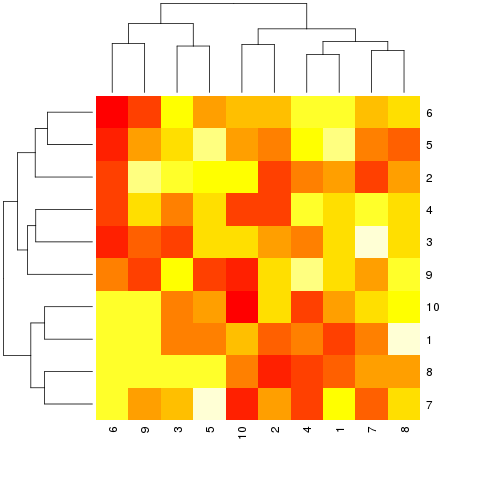

<ListVector - Python:0x7f761004a088 / R:0x2c40c00>
[IntVector, IntVector, RNULLType, RNULLType]
  rowInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f7604017348 / R:0x2cdadd0>
[       7,        8,        1, ...,        2,        5,        6]
  colInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f75ec7dcbc8 / R:0x2d11670>
[       6,        9,        3, ...,        1,        7,        8]
  Rowv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  Colv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL

In [5]:
#%load_ext rpy2.ipython
#from rpy2.robjects import r
#import rpy2.robjects.numpy2ri
#rpy2.robjects.numpy2ri.activate()

import numpy as np
data = np.random.random((10,10))

%Rpush data
%R heatmap(data)

## Python and Julia

Julia is a new language that is very robust in statistics and optimization. Several big names from R and Python world started developing for it, but it remains a question mark how it will fit in the data science landscape. Gluage in Julia is actually superior to Python due to better designed compilers, so is works much better to call Python or R from Julia. Anyway, to glue a call both ways, one must use this Julia library: https://github.com/JuliaPy/.